Electron Density for some HOCl molecules

# From Ryan

https://gaussian.com/cubegen/

- This would be a good place to start for the cubegen command:
```cubegen 1 density=MP2 cl_hocl_tz.fchk cl_hocl_tz.cube```
- where 1 can be replaced with 8  or however many processors you have access to, but there aren't that many points so it shouldn't take long regardless.
- I can also send you the .py file we were looking at earlier if you think that would be helpful. I don't recommend trying to mold it for your use, but it may be a good starting point for you
- If I had a lot of cubegens to run, I would put them in a bash script .sh file which may be helpful as well.

Here's that file I was showing earlier that is crap but has most of the code infrastructure already there. Instead of ctrl+c and ctrl+v-ing it, make sure you understand what's happening lol.

In [3]:
# %load extractDensity.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import scipy as sp
from mpl_toolkits.mplot3d import Axes3D
import numpy.linalg as la
import sys 

def genXYZ(theta, XYZ):
    """Generates the 3D rotation matrix about X, Y, or Z by theta radians"""
    theta = [theta] if isinstance(theta, float) else theta
    rotM = np.zeros((len(theta), 3, 3))
    zeroLth = np.zeros(len(theta))
    if XYZ == 0:
        rotM[:, 0] = np.tile([1, 0, 0], (len(theta)))
        rotM[:, 1] = np.column_stack((zeroLth, np.cos(theta), -1 * np.sin(theta)))
        rotM[:, 2] = np.column_stack((zeroLth, np.sin(theta), np.cos(theta)))
    elif XYZ == 1:
        rotM[:, 0] = np.column_stack((np.cos(theta), zeroLth, -1 * np.sin(theta)))
        rotM[:, 1] = np.tile([0, 1, 0], len(theta), 1)
        rotM[:, 2] = np.column_stack((np.sin(theta), zeroLth, np.cos(theta)))
    elif XYZ == 2:
        rotM[:, 0, :] = np.column_stack((np.cos(theta), -1 * np.sin(theta), zeroLth))
        rotM[:, 1, :] = np.column_stack((np.sin(theta), np.cos(theta), zeroLth))
        rotM[:, 2, :] = np.tile([0, 0, 1], len(theta))
    return rotM


def rotateGeoms(rotMs, geoms):
    """Takes in a stack of rotation matrices and applies it to a stack of geometries."""
    if len(rotMs.shape) == 2:
        rotMs = np.expand_dims(rotMs,0)
    if len(geoms.shape) == 2:
        geoms = np.expand_dims(geoms,0)
    new_geoms = np.expand_dims(geoms, -1)  # nxmx3x1
    new_rotms = np.expand_dims(rotMs, 1)  # nx1x3x3
    rot_geoms = np.matmul(new_rotms, new_geoms)
    return rot_geoms.squeeze()

def rotateVector(rotMs, vecc):
    """Takes in a stack of rotation matrices and applies it to a stack of vector"""
    new_vecc = np.expand_dims(vecc, -1)  # nx3x1
    rot_vecs = np.matmul(rotMs, new_vecc).squeeze()
    return rot_vecs


def plotScatter3DDensity(arrZ,densityZ,atmArZ, flname):
    # dmax = np.amax(density)
    # dmin = np.amin(density)
    # vdata = np.amax([np.abs(dmin),np.abs(dmax)])
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    densityZ[np.abs(densityZ) < 0.001] = np.nan
    ax.scatter(arrZ[0], arrZ[1], arrZ[2], cmap='seismic', c=densityZ.flatten(), alpha=0.1)
    for inum, i in enumerate(atmArZ):
        if atmStr[inum] == 'O':
            ax.scatter(i[0], i[1], i[2], c='r', s=200, alpha=1.0)
        else:
            ax.scatter(i[0], i[1], i[2], c='grey', s=200, alpha=1.0)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    plt.show()
    # plt.savefig(flname+".png")
    plt.close()

def rotToXAx(arrOld,atmArOld,origN,xaxN,xyp=None):
    originC = atmAr[origN]
    arrOld[0] -= originC[0]
    arrOld[1] -= originC[1]
    arrOld[2] -= originC[2]
    atmAr2 = np.copy(atmArOld)
    atmAr2 -= originC[np.newaxis, :]
    xaxNew = atmArOld[xaxN]-originC

    xc = xaxNew[0]
    yc = xaxNew[1]
    zc = xaxNew[2]
    theta = np.arctan2(-zc, yc)
    alpha = np.arctan2((-1 * (yc * np.cos(theta) - np.sin(theta) * zc)), xc)
    r1 = genXYZ(theta, 0).squeeze()
    r2 = genXYZ(alpha, 2).squeeze()
    rotM = np.matmul(r2, r1)
    xf = arrOld[0].flatten()
    yf = arrOld[1].flatten()
    zf = arrOld[2].flatten()
    xyzf = np.array((xf, yf, zf)).T
    rotXYZF = rotateVector(rotM, xyzf)
    # atmArN = rotateGeoms(rotM, atmArOld)
    atmArN = rotateGeoms(rotM, atmAr2)
    if xyp is None:
        xrf = np.reshape(rotXYZF[:, 0], ndim)
        yrf = np.reshape(rotXYZF[:, 1], ndim)
        zrf = np.reshape(rotXYZF[:, 2], ndim)

    else:
        xypVec = atmArN[xyp]
        z = xypVec[2]
        y = xypVec[1]
        beta = np.arctan2(-1 * z, y)
        r3 = genXYZ(beta,0).squeeze()
        rotXYZFF = rotateVector(r3, rotXYZF)
        atmArN = rotateGeoms(r3,atmArN)
        xrf = np.reshape(rotXYZFF[:, 0], ndim)
        yrf = np.reshape(rotXYZFF[:, 1], ndim)
        zrf = np.reshape(rotXYZFF[:, 2], ndim)
    arrp = [xrf, yrf, zrf]
    return arrp,atmArN
    
def integrateWithCylinder(myMesh,
                          myAtmCds,
                          myCylrad,
                          origN,
                          xaxiN,
                          nbinz,
                          myshiftL,
                          myshiftR,
                          myAtmStr,
                          flnPng,
                          split=False):
    pltSave=False
    # integrate along oo axis the electron density
    xyzR = np.array((myMesh[0].flatten(),
                     myMesh[1].flatten(),
                     myMesh[2].flatten())).T
    # dx = np.abs(xyzR[1,0]-xyzR[0,0])
    # dy = np.abs(xyzR[1,1]-xyzR[0,1])
    # dz = np.abs(xyzR[1,2]-xyzR[0,2])
    # print("DXDYDZ",dx,dy,dz,dx*dy*dz)
    qualYZ = np.sqrt(xyzR[:, 1] ** 2 + xyzR[:, 2] ** 2) <= myCylrad
    xax = myAtmCds[xaxiN] - myAtmCds[origN]
    theDist = la.norm(xax)
    scanPts = np.linspace(0 - myshiftL, theDist + myshiftR, num=nbinz + 1)
    centerz = 0.5 * (scanPts[1:] + scanPts[:-1])
    pltData = np.zeros((len(centerz), 2))
    print("SCANPT",scanPts[1]-scanPts[0])
    if not split:
        for inum, i in enumerate(scanPts[:-1]):
            qq = np.logical_and(i < xyzR[:, 0], xyzR[:, 0] < (i + 1))
            denPt = np.sum(density.flatten()[qualYZ * qq])*dxO*dyO*dzO/(scanPts[1]-scanPts[0])
            pltData[inum] = [centerz[inum], denPt]
    else:
        qualNY = xyzR[:, 1] < 0
        qualPY = xyzR[:, 1] > 0
        pltDataL = np.copy(pltData)
        pltDataR = np.copy(pltData)
        for inum, i in enumerate(scanPts[:-1]):
            qq = np.logical_and(i < xyzR[:, 0], xyzR[:, 0] < (i + 1))
            denPtR = np.sum(density.flatten()[qualPY*qualYZ * qq])*dxO*dyO*dzO*(scanPts[1]-scanPts[0])
            denPtL = np.sum(density.flatten()[qualNY*qualYZ * qq])*dxO*dyO*dzO*(scanPts[1]-scanPts[0])
            pltDataR[inum] = [centerz[inum], denPtR]
            pltDataL[inum] = [centerz[inum], denPtL]

    if origN == 4-1 and xaxi == 0:
        Ohdist = la.norm(myAtmCds[4-1]-myAtmCds[6-1])
        np.savetxt(flnPng+"_OOHcds.txt",np.array([0.0,theDist,Ohdist]))
    else:
        np.savetxt(flnPng+"_OHcds.txt",np.array([0.0,theDist]))
    #save data
    if not split:
        np.savetxt(flnPng+"_pltData.txt",pltData)
    else:
        np.savetxt(flnPng + "pltData_Left.txt", pltDataL)
        np.savetxt(flnPng + "pltData_Right.txt", pltDataR)


class MidpointNormalize(matplotlib.colors.Normalize):
    def __init__(self, vmin, vmax, midpoint=0, clip=False):
        self.midpoint = midpoint
        matplotlib.colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        normalized_min = max(0, 1 / 2 * (1 - abs((self.midpoint - self.vmin) / (self.midpoint - self.vmax))))
        normalized_max = min(1, 1 / 2 * (1 + abs((self.vmax - self.midpoint) / (self.midpoint - self.vmin))))
        normalized_mid = 0.5
        x, y = [self.vmin, self.midpoint, self.vmax], [normalized_min, normalized_mid, normalized_max]
        return sp.ma.masked_array(sp.interp(value, x, y))

def TwoDProj(myMesh,
             myAtmCds,
             myCylrad,
             origN,
             xaxiN,
             nbinz,
             myshiftL,
             myshiftR,
             myAtmStr,
             flnPng):
    print('hi')
    xyzR = np.array((myMesh[0].flatten(),
                     myMesh[1].flatten(),
                     myMesh[2].flatten())).T
    xax = myAtmCds[xaxiN] - myAtmCds[origN]
    theDist = xax[0]
    xypA = myAtmCds[6-1]
    # define a square (2d histogram) in the xy plane where we will sum up the z valz
    scanPtsX = np.linspace(0 - myshiftL, theDist + myshiftR, num=nbinz + 1)
    scanPtsY = np.linspace(0 - myshiftL, theDist + myshiftR, num=nbinz + 10)
    centerzX = 0.5 * (scanPtsX[1:] + scanPtsX[:-1])
    centerzY = 0.5 * (scanPtsY[1:] + scanPtsY[:-1])
    twoDXY = np.meshgrid(scanPtsX,scanPtsY)
    twoD = np.zeros((len(centerzX),len(centerzY)))
    for inum,i in enumerate(scanPtsX[:-1]):
        for jnum,j in enumerate(scanPtsY[:-1]):
            qq = np.logical_and(i < xyzR[:, 0], xyzR[:, 0] < (i + 1))
            rr = np.logical_and(j < xyzR[:,1], xyzR[:, 1] < (j + 1))
            denPt = np.sum(density.flatten()[qq*rr])
            twoD[inum,jnum] = denPt
    plt.contour(centerzX,centerzY,twoD.T,levels=25,colors='k')
    cmmr1 = matplotlib.cm.get_cmap('PRGn')
    norm = MidpointNormalize(vmin=-0.75, vmax=4, midpoint=0)
    plt.contourf(centerzX,centerzY,twoD.T,levels=25,cmap=cmmr1,norm=norm)
    circle1 = plt.Circle((theDist, 0), 0.1, color='grey', fill=True)
    circle2 = plt.Circle((xypA[0],xypA[1]),0.1, color='grey', fill=True)
    circle3 = plt.Circle((0, 0), 0.1, color='r', fill=True)
    plt.gcf().gca().add_artist(circle1)
    plt.gcf().gca().add_artist(circle2)
    plt.gcf().gca().add_artist(circle3)
    plt.xlabel("X (Bohr)")
    plt.ylabel("Y (Bohr)")
    plt.colorbar()
    plt.savefig(flnPng + ".png", dpi=400)


#~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!~!
atmDict = {1: 'H', 
           3: 'Li',
           8: 'O',
           11:'Na',
           55: 'Cs'}
fileOfInterest = sys.argv[1]
print(fileOfInterest)
cylCont = int(sys.argv[2])
a = open(fileOfInterest,"r")
lin = a.readlines()
beginningE = int(lin[2].split()[0]) + 6
linNum = 1
atmCt = 0
atmStr= []
ndim= []
delta = []
gridN = 0
for line in lin:
    if linNum == 3:
        splt = line.split()
        info = [float(q) for q in splt]
        
        nAtoms = int(info[0])
        atmAr = np.zeros((nAtoms,3))
        # atmStr = np.tile(["O","H","H"],nAtoms//3)
        origin = np.array(info[1:-1])
    elif 4 <= linNum <= 6:
        splt = line.split()
        xyzZ = [float(q) for q in splt]
        
        ndim.append(int(xyzZ[0]))
        if linNum == 4:
            delta=xyzZ[1]
    elif 7 <= linNum <= beginningE:
        splt = line.split()
        xyzZ = [float(q) for q in splt][1:]
        atmStr.append(atmDict[int(splt[0])])
        atmAr[atmCt] = xyzZ[1:]
        atmCt+=1
    elif linNum > beginningE:
        pass
    linNum+=1
a.close()
k =  pd.read_table(fileOfInterest,delim_whitespace=True,header=None, skiprows=np.arange(beginningE))
xx=k.to_numpy()
xxp = xx[np.logical_not(np.isnan(xx))]
density = np.reshape(xxp,ndim)
cds = np.zeros(xxp.shape)
cdsX = np.linspace(origin[0],origin[0]+delta*ndim[0],num=ndim[0])
cdsY = np.linspace(origin[1],origin[1]+delta*ndim[1],num=ndim[1])
cdsZ = np.linspace(origin[2],origin[2]+delta*ndim[2],num=ndim[2])
arr = np.meshgrid(cdsX,cdsY,cdsZ,indexing='ij')
dxO = cdsX[1]-cdsX[0]
dyO = cdsY[1]-cdsY[0]
dzO = cdsZ[1]-cdsZ[0]
print("DXDYDZO",dxO,dyO,dzO,dxO*dyO*dzO)
nbins = 40
shiftL = 1.0
shiftR = 1.0
cylRad = 1.0
#translate and rotate
# plotScatter3DDensity(arrp,density,atmAr_tr,'test_rotate')

if cylCont == 0: #Cylinder
    orig = 4-1
    # xaxi = 1-1
    xaxi = 5-1
    arrp,atmAr_tr = rotToXAx(arr,atmAr,orig,xaxi)
    split=False
    integrateWithCylinder(arrp,
          atmAr_tr,
          cylRad,
          orig,
          xaxi,
          nbins,
          shiftL,
          shiftR,
          atmStr,
          fileOfInterest[:-5]+"_"+atmStr[orig]+str(orig+1)+atmStr[xaxi]+str(xaxi+1),
          split)
else:
    orig = 4-1
    xaxi = 5-1 #'free' OH
    xyp = 1-1
    shiftL = 0.5
    shiftR = 0.5
    arrp,atmAr_tr = rotToXAx(arr,atmAr,orig,xaxi,xyp)
    TwoDProj(arrp,
            atmAr_tr,
            cylRad,
            orig,
            xaxi,
            nbins,
            shiftL,
            shiftR,
            atmStr,
            fileOfInterest[:-5]+"_"+atmStr[orig]+str(orig+1)+atmStr[xaxi]+str(xaxi+1))







# From Anne:

I think I have put all the files you need in the /gscratch/ilahie/mccoygrp/hocl/eq_jobs directory on MOX.  Let me know if it looks like I missed anything

# Me

- I found the directory and used cubegen with the options specified by Ryan above to make ```br_hocl_tz.cube```

General Plan:
- Make a class that reads in a cube file and gives functionality
- 

In [37]:
import sys
sys.path.append('./CGH_Toolbox/')
import density_cube as dc
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from matplotlib.colors import LogNorm
import numpy as np
import nglview as nv
import MDAnalysis as mda

In [2]:
c = dc.cube(filename='HOCl/br_hocl_tz.cube')

DXDYDZO 0.2721861170212758 0.27301032876712306 0.27301032876712306 0.02028729413998761
hello


In [3]:
c.cdsX[0]

-12.5833

In [23]:
c.atmAr

array([[ 2.629767e+00,  1.881155e+00,  3.000000e-06],
       [ 8.553900e-01,  1.139494e+00, -3.800000e-05],
       [ 4.506029e+00, -6.919500e-01,  0.000000e+00],
       [-2.814172e+00, -1.264450e-01,  0.000000e+00]])

In [11]:
density_Zsum = np.zeros(c.density[:,:,0].shape)

In [23]:
c.density[:,:,0].shape

(95, 74)

In [24]:
c.density.shape

(95, 74, 74)

In [4]:
c.atmStr

['O', 'H', 'Cl', 'Br']

In [12]:
for i in range(len(c.density[0,0,:])):
    density_Zsum = density_Zsum + c.density[:,:,i]

In [34]:
c.cdsZ[36]

0.05924383561643687

In [6]:
br_hocl = mda.Universe("./HOCl/br_hocl_tz.xyz")
br_hocl_view = nv.show_mdanalysis(br_hocl)
br_hocl_view

NGLWidget()

In [47]:
fig = plt.figure()
ax = plt.axes()

ax.scatter(c.atmAr[:,0][0], c.atmAr[:,1][0], color='red')
ax.scatter(c.atmAr[:,0][1], c.atmAr[:,1][1], color='gray')
ax.scatter(c.atmAr[:,0][2], c.atmAr[:,1][2], color='green')
ax.scatter(c.atmAr[:,0][3], c.atmAr[:,1][3], color='maroon')
ax.set_xlim(-12,12)
ax.set_ylim(-10,10)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

(-10.0, 10.0)

In [46]:
%matplotlib widget
fig, ax = plt.subplots()
CS = ax.contourf(c.cdsX, c.cdsY, c.density[:,:,35].T)
ax.scatter(c.atmAr[:,0][0], c.atmAr[:,1][0], color='red')
ax.scatter(c.atmAr[:,0][1], c.atmAr[:,1][1], color='gray')
ax.scatter(c.atmAr[:,0][2], c.atmAr[:,1][2], color='green')
ax.scatter(c.atmAr[:,0][3], c.atmAr[:,1][3], color='maroon')
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title('Simplest default with labels')
fig.colorbar(CS)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [46]:
%matplotlib widget
slices = [20,30,40,50]
fig, ax = plt.subplots(2,2)
for i in range(len(2)):
    for j in range(len(2)):
        CS = ax[i,j].contourf(c.cdsX, c.cdsY, c.density[:,:,slices[2*(i+1)+j+1]].T)
        ax[i,j].scatter(c.atmAr[:,0][0], c.atmAr[:,1][0], color='red')
        ax[i,j].scatter(c.atmAr[:,0][1], c.atmAr[:,1][1], color='gray')
        ax[i,j].scatter(c.atmAr[:,0][2], c.atmAr[:,1][2], color='green')
        ax[i,j].scatter(c.atmAr[:,0][3], c.atmAr[:,1][3], color='maroon')
        #ax.clabel(CS, inline=True, fontsize=10)
        #ax.set_title('Simplest default with labels')
        fig.colorbar(CS)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: 'Figure' object has no attribute 'scale'

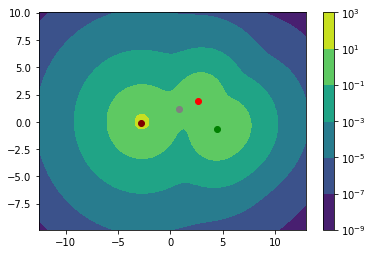

In [29]:
fig, ax = plt.subplots()
CS = ax.contourf(c.cdsX, c.cdsY, density_Zsum.T, locator=ticker.LogLocator())
fig.colorbar(CS)
ax.scatter(c.atmAr[:,0][0], c.atmAr[:,1][0], color='red')
ax.scatter(c.atmAr[:,0][1], c.atmAr[:,1][1], color='gray')
ax.scatter(c.atmAr[:,0][2], c.atmAr[:,1][2], color='green')
ax.scatter(c.atmAr[:,0][3], c.atmAr[:,1][3], color='maroon')
fig.scale('log')
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title('Simplest default with labels')
#CS.colorbar()
plt.show()

In [17]:
c.density.min()

2.39825e-13

In [48]:
fig, ax = plt.subplots()
CS = ax.contourf(c.cdsX, c.cdsY, density_Zsum.T, norm=LogNorm())
C = ax.contour(c.cdsX, c.cdsY, density_Zsum.T, norm=LogNorm(), colors='k')
fig.colorbar(CS)
ax.scatter(c.atmAr[:,0][0], c.atmAr[:,1][0], color='red')
ax.scatter(c.atmAr[:,0][1], c.atmAr[:,1][1], color='gray')
ax.scatter(c.atmAr[:,0][2], c.atmAr[:,1][2], color='green')
ax.scatter(c.atmAr[:,0][3], c.atmAr[:,1][3], color='maroon')
#ax.clabel(CS, inline=True, fontsize=10)
#ax.set_title('Simplest default with labels')
#CS.colorbar()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [26]:
c.atmAr[:,0]

array([ 2.629767,  0.85539 ,  4.506029, -2.814172])

chlorine is green

run colinear jobs for Cl, Br, I